<a href="https://colab.research.google.com/github/shawntharoo/GoogleColabProjects/blob/main/Copy_of_MBA509_A3_Detect_Actions_Videos_Perceiver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 142345_Kaluthara Koralalage Sandakelum Tharindu Adikaram_video_detection

# This notebook shows how to create and apply PerceiverIO to detect actions in videos that contain audio.

# It also fixes Google low_cpu_mem_usage issue.

# It is based on the work of Google Deepmind: 

* https://arxiv.org/abs/2103.03206

* https://arxiv.org/abs/2107.14795


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 596 kB 5.1 MB/s 
     |████████████████████████████████| 86 kB 5.8 MB/s 
     |████████████████████████████████| 6.6 MB 58.7 MB/s 


In [ ]:
# this is the workaround for GPU error cuDNN
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 43 not upgraded.
Need to get 430 MB of archives.
After this operation, 3,139 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 12s (36.7 MB/s)
(Reading database ... 155632 files and directories currently installed.)
Removing libcudnn8-dev (8.0.5.39-1+cuda11.1) ...
(Reading database ... 155610 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb ...
Unpacking libcudnn8 (8.1.0.77-1+

In [ ]:
!pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 106 kB 5.0 MB/s 


In [ ]:
import base64
import functools
import os
import pickle
import ssl
import re
import tempfile

from urllib import request

import cv2
import imageio
import numpy as np
import scipy.io.wavfile

from IPython.display import HTML

# Crop and center video

In [ ]:
def crop_center_square(frame):
  y, x = frame.shape[0:2]
  min_dim = min(y, x)
  start_x = (x // 2) - (min_dim // 2)
  start_y = (y // 2) - (min_dim // 2)
  return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

# Load video

In [ ]:
def load_video(path, max_frames=0, resize=(224, 224)):
  cap = cv2.VideoCapture(path)
  frames = []
  try:
    while True:
      ret, frame = cap.read()
      if not ret:
        break
      frame = crop_center_square(frame)
      frame = cv2.resize(frame, resize)
      frame = frame[:, :, [2, 1, 0]]
      frames.append(frame)
      
      if len(frames) == max_frames:
        break
  finally:
    cap.release()
  return np.array(frames) / 255.0


# Covert video to animated GIFs

In [ ]:
def to_gif_video1(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation1.gif', converted_images, fps=25)
  with open('./animation1.gif', 'rb') as f:
    gif_64 = base64.b64encode(f.read()).decode('utf-8')
  return HTML('<img src="data:image/gif;base64,%s"/>' % gif_64)


In [ ]:
def to_gif_video2(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation2.gif', converted_images, fps=25)
  with open('./animation2.gif', 'rb') as f:
    gif_64 = base64.b64encode(f.read()).decode('utf-8')
  return HTML('<img src="data:image/gif;base64,%s"/>' % gif_64)


# Play audio

In [ ]:
def play_audio(data, sample_rate=48000):
  scipy.io.wavfile.write('tmp_audio.wav', sample_rate, data)

  with open('./tmp_audio.wav', 'rb') as f:
    audio_64 = base64.b64encode(f.read()).decode('utf-8')
  return HTML('<audio controls src="data:audio/wav;base64,%s"/>' % audio_64)

# Show video and audio samples together

In [ ]:
def table(elements):
  row = ['<td>%s</td>' % el.data for el in elements]
  return HTML('<table><tr>%s</tr></table>' % ''.join(row))

# Remember to load your advertising video to **YOUR GOOGLE DRIVE**

In [ ]:
first_advertising_video_path = '/content/drive/MyDrive/COCO MADEMOISELLE. L’Eau Privée - CHANEL Fragrance.mp4'

In [ ]:
second_advertising_video_path = '/content/drive/MyDrive/YVES SAINT LAURENT - BLACK OPIUM EDP EXTREME 21 HERO 16-9 15S INTER VFR.mp4'

# Extract audio from video and save as a wav file

In [ ]:
first_video_path = first_advertising_video_path

# Extract audio using FFMPEG and encode as pcm float wavfile (only format readable by scipy.io.wavfile).
!yes | ffmpeg -i "$first_video_path"  -c copy  -f wav -map 0:a pcm_f32le -ar 48000 output1.wav

sample_rate, audio = scipy.io.wavfile.read("output1.wav")
if audio.dtype == np.int16:
  audio = audio.astype(np.float32) / 2**15
elif audio.dtype != np.float32:
  raise ValueError('Unexpected datatype. Model expects sound samples to lie in [-1, 1]')

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [ ]:
second_video_path = second_advertising_video_path

# Extract audio using FFMPEG and encode as pcm float wavfile (only format readable by scipy.io.wavfile).
!yes | ffmpeg -i "$second_video_path"  -c copy  -f wav -map 0:a pcm_f32le -ar 48000 output2.wav

sample_rate, audio = scipy.io.wavfile.read("output2.wav")
if audio.dtype == np.int16:
  audio = audio.astype(np.float32) / 2**15
elif audio.dtype != np.float32:
  raise ValueError('Unexpected datatype. Model expects sound samples to lie in [-1, 1]')

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

#  Load videos

In [ ]:
first_video = load_video(first_video_path)

In [ ]:
second_video = load_video(second_video_path)

# Initialise Perceiver for Multimodal data and use GPU

In [ ]:
from transformers import PerceiverForMultimodalAutoencoding
from tqdm.notebook import tqdm
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = PerceiverForMultimodalAutoencoding.from_pretrained("deepmind/multimodal-perceiver",low_cpu_mem_usage=False)
model.to(device)

PerceiverForMultimodalAutoencoding(
  (perceiver): PerceiverModel(
    (input_preprocessor): PerceiverMultimodalPreprocessor(
      (padding): ParameterDict(
          (audio): Parameter containing: [torch.cuda.FloatTensor of size 1x303 (GPU 0)]
          (image): Parameter containing: [torch.cuda.FloatTensor of size 1x461 (GPU 0)]
          (label): Parameter containing: [torch.cuda.FloatTensor of size 1x4 (GPU 0)]
      )
      (mask): ParameterDict(
          (audio): Parameter containing: [torch.cuda.FloatTensor of size 1x704 (GPU 0)]
          (image): Parameter containing: [torch.cuda.FloatTensor of size 1x704 (GPU 0)]
          (label): Parameter containing: [torch.cuda.FloatTensor of size 1x704 (GPU 0)]
      )
    )
    (output_postprocessor): PerceiverMultimodalPostprocessor(
      (modalities): ModuleDict(
        (audio): PerceiverAudioPostprocessor(
          (classifier): Linear(in_features=512, out_features=16, bias=True)
        )
        (image): PerceiverProjectionPos

# Encode video

* into images
* and audio accompaniment

In [ ]:
def autoencode_video(images, audio):
  
  # only create entire video once as inputs
  inputs = {'image': torch.from_numpy(np.moveaxis(images, -1, 2)).float().to(device),
          'audio': torch.from_numpy(audio).to(device),
          'label': torch.zeros((images.shape[0], 700)).to(device)}
  
  nchunks = 128
  reconstruction = {}
  for chunk_idx in tqdm(range(nchunks)):
        image_chunk_size = np.prod(images.shape[1:-1]) // nchunks
        audio_chunk_size = audio.shape[1] // SAMPLES_PER_PATCH // nchunks
        subsampling = {
            'image': torch.arange(
                image_chunk_size * chunk_idx, image_chunk_size * (chunk_idx + 1)),
            'audio': torch.arange(
                audio_chunk_size * chunk_idx, audio_chunk_size * (chunk_idx + 1)),
            'label': None,
        }
        
        # forward pass
        with torch.no_grad():

          # this is the perceiver
          outputs = model(inputs=inputs, subsampled_output_points=subsampling)

          output = {k:v.cpu() for k,v in outputs.logits.items()}
        
        reconstruction['label'] = output['label']
        if 'image' not in reconstruction:
          reconstruction['image'] = output['image']
          reconstruction['audio'] = output['audio']
        else:
          reconstruction['image'] = torch.cat(
              [reconstruction['image'], output['image']], dim=1)
          reconstruction['audio'] = torch.cat(
              [reconstruction['audio'], output['audio']], dim=1)
          
        del outputs
        
  # finally, reshape image and audio modalities back to original shape
  reconstruction['image'] = torch.reshape(reconstruction['image'], images.shape)
  reconstruction['audio'] = torch.reshape(reconstruction['audio'], audio.shape)
  return reconstruction

  return None

# Take samples of audio at same fixed-sized patches as video

### First video

In [ ]:
AUDIO_SAMPLES_PER_FRAME = 48000 // 25
SAMPLES_PER_PATCH = 16

# Auto-encode the first 16 frames of the video and one of the audio channels
first_reconstruction = autoencode_video(first_video[None, :16], audio[None, :16*AUDIO_SAMPLES_PER_FRAME, 0:1])

  0%|          | 0/128 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### Encode second video

In [ ]:
AUDIO_SAMPLES_PER_FRAME = 48000 // 25
SAMPLES_PER_PATCH = 16

# Auto-encode the first 16 frames of the video and one of the audio channels
second_reconstruction = autoencode_video(second_video[None, :16], audio[None, :16*AUDIO_SAMPLES_PER_FRAME, 0:1])

  0%|          | 0/128 [00:00<?, ?it/s]

# Display the learned re-constructions

### First video

""

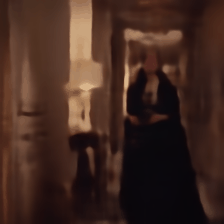

In [ ]:
# Visualize reconstruction of first 16 frames
table([to_gif_video1(first_reconstruction["image"][0].numpy()), play_audio(np.array(first_reconstruction["audio"][0].numpy()))])

### Second Video

""

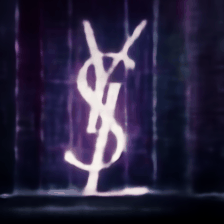

In [ ]:
# Visualize reconstruction of first 16 frames
table([to_gif_video2(second_reconstruction["image"][0].numpy()), play_audio(np.array(second_reconstruction["audio"][0].numpy()))])

# Predict actions in video and audio

### First video

In [ ]:
# Print top 20 predicted labels
scores, indices = torch.topk(torch.softmax(first_reconstruction["label"], dim=1), k=50)
for score, index in zip(scores[0], indices[0]):
  print("%s: %s" % (model.config.id2label[index.item()], score.item()*100))

giving or receiving award: 7.782378792762756
robot dancing: 3.9940334856510162
opening door: 3.854144364595413
recording music: 2.879207022488117
acting in play: 2.7964111417531967
uncorking champagne: 2.52241063863039
attending conference: 2.2972669452428818
krumping: 2.2398527711629868
closing door: 2.2375982254743576
auctioning: 2.091241627931595
playing darts: 1.8671359866857529
throwing knife: 1.6153113916516304
taking photo: 1.542373187839985
contact juggling: 1.4997931197285652
beatboxing: 1.4652467332780361
moving furniture: 1.4241205528378487
playing laser tag: 1.404645387083292
punching bag: 1.2745979242026806
card throwing: 1.258847676217556
high kick: 1.205821055918932
pouring beer: 1.1864542961120605
playing saxophone: 1.1520469561219215
pull ups: 1.145329512655735
sword swallowing: 1.0347140952944756
belly dancing: 0.9999522008001804
cosplaying: 0.9986851364374161
drop kicking: 0.9214815683662891
tango dancing: 0.9211077354848385
dining: 0.9187087416648865
walking on stil

### Second Video

In [ ]:
# Print top 20 predicted labels
scores, indices = torch.topk(torch.softmax(second_reconstruction["label"], dim=1), k=50)
for score, index in zip(scores[0], indices[0]):
  print("%s: %s" % (model.config.id2label[index.item()], score.item()*100))

trapezing: 50.14415979385376
swinging on something: 12.005652487277985
spinning plates: 5.931932479143143
tightrope walking: 4.051560163497925
contorting: 3.903166577219963
dancing ballet: 3.0295079573988914
slacklining: 1.2226085178554058
tap dancing: 1.140960119664669
sword swallowing: 0.6035514641553164
recording music: 0.4872450605034828
bungee jumping: 0.4369847010821104
pouring wine: 0.41346861980855465
singing: 0.41040400974452496
roasting marshmallows: 0.3886811202391982
playing laser tag: 0.3536338219419122
sailing: 0.35353791899979115
belly dancing: 0.35243374295532703
shooting off fireworks: 0.34604547545313835
walking on stilts: 0.31627120915800333
tagging graffiti: 0.31388765200972557
dunking basketball: 0.30882551800459623
contact juggling: 0.3086392767727375
looking in mirror: 0.2786846598610282
robot dancing: 0.24197676684707403
welding: 0.23621388245373964
playing didgeridoo: 0.23372042924165726
tie dying: 0.2292111050337553
lighting fire: 0.22830052766948938
throwing 